# Frac Production Data Cleaning - Montana

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
# Cleaning import
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

## Montana Production Data

In [2]:
# Read in Montana wells production data
df = pd.read_csv('bakkenWells.csv')
df.head()

,API10,API12,API14,Well Name,Well Number,Lease Name,Operator Alias,Reported Operator,Field,County/Parish,...,Quarter Quarter,District,Abstract,Block,Survey,Surface Hole Latitude (WGS84),Surface Hole Longitude (WGS84),Bottom Hole Latitude (WGS84),Bottom Hole Longitude (WGS84),UWI
0,2508521990,250852199000,25085219900000,GEHRINGER 24-13,#3H,GEHRINGER 24-13,KRAKEN OPERATING,KRAKEN OPERATING LLC,"ELM COULEE, NORTHEAST",ROOSEVELT (MT),...,NaN,NaN,NaN,NaN,NaN,48.156481,-104.166999,48.185870,-104.168678,2508521990
1,2502505017,250250501700,25025050170000,UNIT 24-19H,24-19H,UNIT 24-19H,ENCORE,"ENCORE ENERGY, INC.",LITTLE BEAVER,FALLON (MT),...,SESW,NaN,NaN,NaN,NaN,46.085196,-104.072119,46.085196,-104.072119,25-025-05017-00-00
2,2502505264,250250526400,25025052640000,UNIT 22-5B,22-5BH,UNIT 22-5B,DENBURY ONSHORE,"DENBURY ONSHORE, LLC",PENNEL,FALLON (MT),...,NENW,NaN,NaN,NaN,NaN,46.392217,-104.232157,46.387183,-104.239745,25-025-05264-00-00
3,2502505280,250250528000,25025052800000,UNIT 22-31C,22-31C,UNIT 22-31C,DENBURY ONSHORE,"DENBURY ONSHORE, LLC",PENNEL,FALLON (MT),...,SENW,NaN,NaN,NaN,NaN,46.403695,-104.272115,46.397814,-104.277832,25-025-05280-00-00
4,2502505671,250250567100,25025056710000,MDU NP 21X-13,21X-13,MDU NP,DENBURY ONSHORE,"DENBURY ONSHORE, LLC",LITTLE BEAVER,FALLON (MT),...,NENW,NaN,NaN,NaN,NaN,46.110572,-104.092437,46.121894,-104.087954,25-025-05671-00-00


Since there are too many columns to look at at once, print the column name and contents for one well to determine what information is in the data frame.

In [3]:
for col in df.columns:
    print(col, '\t\t', df.loc[2,col])

API10 		 2502505264
API12 		 250250526400
API14 		 25025052640000
Well Name 		 UNIT  22-5B
Well Number 		 22-5BH
Lease Name 		 UNIT  22-5B
Operator Alias 		 DENBURY ONSHORE
Reported Operator 		 DENBURY ONSHORE, LLC
Field 		 PENNEL
County/Parish 		 FALLON (MT)
Target Formation 		 SILURO-ORDOVICIAN
DI Landing Zone 		 nan
KB Elevation 		 nan
Ground Elevation 		 3113.0
Measured Depth (TD) 		 9195.0
True Vertical Depth 		 nan
Production Type 		 INJECTION
Well Status 		 ACTIVE
Spud Date 		 1963-02-28
Completion Date 		 1963-05-08
Drill Type 		 H
Upper Perforation 		 nan
Lower Perforation 		 nan
Gross Perforated Interval 		 nan
Horizontal Length 		 2652.78
Wellbore Count (API10) 		 1
Completion Count (API10) 		 1
Treatment Job Count (API10) 		 nan
First Prod Date 		 nan
Start Date (First Treatment Job) 		 nan
End Date (First Treatment Job) 		 nan
First Test Gas Volume 		 nan
First Test Oil Volume 		 nan
First Test Water Volume 		 nan
First Test Hours Tested 		 nan
First Test Production Method

Columns of interest:
- API14 __needs to be our index__
- Measured Depth (TD) is our total depth in case I need to fill in any depth information
- True Vertical Depth 
- Drill Type - __needs to only be horizontal__
- Gross Perforated Interval __needs spaces removed from name__
- Horizontal Length
- First 6 BOE

In [4]:
# Fixing the length of the API numbers and setting them as the index
mtwells = df[['API14','Measured Depth (TD)', 'True Vertical Depth',
             'Horizontal Length','Drill Type','Gross Perforated Interval',
             'First 6 BOE']]

# Renaming columns
mtwells = mtwells.rename(columns={'API14':'APINumber',
                                  'Measured Depth (TD)':'TotalDepth',
                                  'True Vertical Depth': 'VerticalDepth',
                                  'Horizontal Length':'HorizontalLength',
                                  'Gross Perforated Interval':'GrossPerforatedInterval',
                                  'Drill Type':'DrillType',
                                  'First 6 BOE':'First6BOE'})
mtwells.head()

,APINumber,TotalDepth,VerticalDepth,HorizontalLength,DrillType,GrossPerforatedInterval,First6BOE
0,25085219900000,NaN,NaN,10728.96,H,NaN,NaN
1,25025050170000,8520.0,NaN,0.00,H,NaN,5647.67
2,25025052640000,9195.0,NaN,2652.78,H,NaN,NaN
3,25025052800000,8900.0,NaN,2584.62,H,NaN,2606.17
4,25025056710000,8630.0,NaN,4290.20,H,NaN,NaN


It looks like there are a lot of NA values. Let's check them out.

In [5]:
mtwells.notnull().sum()

APINumber                  25425
TotalDepth                 23341
VerticalDepth              20249
HorizontalLength           23752
DrillType                  25425
GrossPerforatedInterval    16545
First6BOE                  13622
dtype: int64

I'll start by setting the API number as the index and selecting only the horizontal wells.

In [6]:

mtwells = mtwells[mtwells.DrillType == 'H'].drop('DrillType', axis=1)
mtwells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25425 entries, 0 to 25424
Data columns (total 6 columns):
APINumber                  25425 non-null int64
TotalDepth                 23341 non-null float64
VerticalDepth              20249 non-null float64
HorizontalLength           23752 non-null float64
GrossPerforatedInterval    16545 non-null float64
First6BOE                  13622 non-null float64
dtypes: float64(5), int64(1)
memory usage: 1.4 MB


Since our entire model is dependent on the first 6 months of production, I need to drop any well that is null in that column.

In [7]:
mtwells = mtwells.dropna(axis=0, subset=['First6BOE'])
mtwells.head()

,APINumber,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE
1,25025050170000,8520.0,NaN,0.00,NaN,5647.67
3,25025052800000,8900.0,NaN,2584.62,NaN,2606.17
5,25025056850000,8652.0,NaN,1451.89,NaN,2171.17
6,25025211090000,8869.0,NaN,3450.64,NaN,790.50
7,25025211170000,8903.0,NaN,3802.94,NaN,4390.17


In [8]:
# Checking null values remaining
mtwells.isnull().sum()

APINumber                     0
TotalDepth                    9
VerticalDepth                24
HorizontalLength              3
GrossPerforatedInterval    1452
First6BOE                     0
dtype: int64

Great! Looks like there are a couple of lengths missing, and a good number of gross perforated intervals, which I should be able to use the same reasoning behind my Colorado imputing of the data.  First, let's make sure that the lenghts are not missing multiple values from the same row, because then I will not be able to back-calulate the information.

In [9]:
mtwells[mtwells.TotalDepth.isnull()]

,APINumber,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE
8692,33105014900000,NaN,NaN,3168.15,NaN,101293.67
12615,33007011400000,NaN,NaN,1863.20,NaN,22146.00
12617,33007011550000,NaN,NaN,66.43,10.0,3010.17
12690,33007011620000,NaN,NaN,73.70,8.0,8638.00
12763,33007012980000,NaN,NaN,4001.75,9.0,20733.67
12764,33007013010000,NaN,NaN,43.57,22.0,28324.83
12771,33007013120000,NaN,NaN,38.31,NaN,7120.17
14834,33013013170000,NaN,NaN,1919.05,NaN,2907.17
23977,33011013920000,NaN,NaN,58.85,9.0,1653.00


I will need to drop all of those rows because I am missing multiple values and unable to calculate the remaining values.

In [10]:
mtwells[mtwells.HorizontalLength.isnull()]

,APINumber,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE
53,25025051730000,8955.0,NaN,NaN,NaN,7916.17
7839,33075013550000,4550.0,NaN,NaN,40.0,3964.33
13720,33009024480000,4490.0,NaN,NaN,69.0,2910.00


I will also need to drop these wells. If I have horizontal length and total depth I can calculate both vertical depth and gross perforated interval.

In [11]:
mtwells = mtwells.dropna(axis=0, subset=['TotalDepth', 'HorizontalLength'])
mtwells.isnull().sum()

APINumber                     0
TotalDepth                    0
VerticalDepth                12
HorizontalLength              0
GrossPerforatedInterval    1447
First6BOE                     0
dtype: int64

Now, I will compute the vertical depth from the difference between the total depth and the horizontal length.

In [12]:
# Calculating vertical depth
mtwells['Calc_VerticalDepth'] = mtwells.TotalDepth = mtwells.HorizontalLength
# Replacing all null values with the calculated values
for i in mtwells[mtwells.VerticalDepth.isnull()].index:
    mtwells.VerticalDepth.loc[i] = mtwells.Calc_VerticalDepth.loc[i]

mtwells = mtwells.drop('Calc_VerticalDepth', axis=1)
mtwells.isnull().sum()

APINumber                     0
TotalDepth                    0
VerticalDepth                 0
HorizontalLength              0
GrossPerforatedInterval    1447
First6BOE                     0
dtype: int64

Great! Now I just want to check the relationship between gross perforated interval and horizontal length to see if the same relationship exists as between those in Colorado.

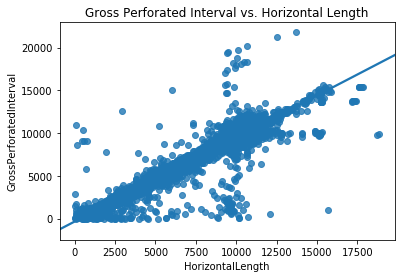

Slope: 0.9170099104613252
Intercept: 1174.7075905518204
R-squared: 0.8994169714466687


In [13]:
# Graphing Gross perforated interval versus horizontal length
temp = mtwells[['GrossPerforatedInterval', 'HorizontalLength']].dropna()
sns.regplot(y=temp.GrossPerforatedInterval, x=temp.HorizontalLength)
plt.title('Gross Perforated Interval vs. Horizontal Length')
plt.show()

m, b, r, p, se = linregress(temp.GrossPerforatedInterval, temp.HorizontalLength)
print('Slope: {}\nIntercept: {}\nR-squared: {}'.format(m,b, r**2))

This is a similar equation for the relationship between the two variables and the R-squared value is around 90%, so I will compute the predicted gross perforated interval using this formula.

In [14]:
mtwells['GPIpred'] = mtwells.HorizontalLength * 0.9170099104613252 + 1174.7075905518204

for i in mtwells[mtwells.GrossPerforatedInterval.isnull()].index:
    mtwells['GrossPerforatedInterval'] = mtwells.GPIpred.loc[i]

mtwells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13610 entries, 1 to 25424
Data columns (total 7 columns):
APINumber                  13610 non-null int64
TotalDepth                 13610 non-null float64
VerticalDepth              13610 non-null float64
HorizontalLength           13610 non-null float64
GrossPerforatedInterval    13610 non-null float64
First6BOE                  13610 non-null float64
GPIpred                    13610 non-null float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


Fantastic.  Now I need to join this data frame with the frac focus data to add in the methods.

## Frac Focus Data

Reading in frac method data

In [15]:
# Reading in frac method data
fracmethod = pd.read_csv('fracmethod_clean.csv', index_col=0)
fracmethod.head()

,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,
4226932868,1,0,1,1.0,8552.338261
1007203590000,1,1,0,1.0,177493.467769
1007203600000,1,1,0,1.0,151188.848979
1007203610000,1,1,0,1.0,219070.601388
1007203620000,1,1,0,1.0,245962.571934


In [16]:
mtwells.head(20)

,APINumber,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE,GPIpred
1,25025050170000,0.00,0.00,0.00,1775.926798,5647.67,1174.707591
3,25025052800000,2584.62,2584.62,2584.62,1775.926798,2606.17,3544.829745
5,25025056850000,1451.89,1451.89,1451.89,1775.926798,2171.17,2506.105109
6,25025211090000,3450.64,3450.64,3450.64,1775.926798,790.50,4338.978668
7,25025211170000,3802.94,3802.94,3802.94,1775.926798,4390.17,4662.041259
8,25025214680000,2614.12,2614.12,2614.12,1775.926798,20056.83,3571.881538
143,25025211980000,1823.29,1823.29,1823.29,1775.926798,6571.50,2846.682590
373,25085219780000,10071.91,10071.91,10071.91,1775.926798,112335.67,10410.748878
375,25085219820000,10149.72,10149.72,10149.72,1775.926798,103295.83,10482.101419
376,25085219830000,10185.45,10185.45,10185.45,1775.926798,109993.67,10514.866183


I need to set the index as the API number before joining the two data frames.

In [18]:
# Set API number as index
mtwells = mtwells.set_index('APINumber')
# Joining Montana wells with Frac Method data
mtwells2 = mtwells.join(fracmethod, how='inner')

In [20]:
print(mtwells2.shape)
mtwells2.head()

(9655, 11)


,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE,GPIpred,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,,,,,,,
25085219780000,10071.91,10071.91,10071.91,1775.926798,112335.67,10410.748878,1,0,0,0.0,1.253843e+07
25085219820000,10149.72,10149.72,10149.72,1775.926798,103295.83,10482.101419,1,0,0,0.0,1.212962e+07
25085219830000,10185.45,10185.45,10185.45,1775.926798,109993.67,10514.866183,1,0,0,0.0,1.031478e+07
33025020720000,9331.72,10775.58,9331.72,1775.926798,36293.00,9731.987312,1,0,1,1.0,2.607105e+06
33025020730000,10601.98,10849.07,10601.98,1775.926798,27982.17,10896.828321,1,0,1,1.0,1.777026e+06


Great, I have about 9.6K wells in Montana, now I just need to engineer my binned horizontal lenghts, the square root of non-perforated feet, and the square root of sand mass.

In [21]:
# Creating bins for the three general horizontal legnths
bins = [0,6500,8500,2500000]
mtwells2['hzlen_bin'] = pd.cut(mtwells2['HorizontalLength'], bins,
                              labels = ['<1', '1-2', '>2'])

mtwells2['nphf_sqrt'] = np.sqrt(mtwells2.HorizontalLength - mtwells2.GrossPerforatedInterval + 6000)

mtwells2['sqrtsandmass'] = np.sqrt(mtwells2.sandmass)
mtwells2.head()

,TotalDepth,VerticalDepth,HorizontalLength,GrossPerforatedInterval,First6BOE,GPIpred,slick,gel,xlinkgel,hybrid,sandmass,hzlen_bin,nphf_sqrt,sqrtsandmass
APINumber,,,,,,,,,,,,,,
25085219780000,10071.91,10071.91,10071.91,1775.926798,112335.67,10410.748878,1,0,0,0.0,1.253843e+07,>2,119.565811,3540.964318
25085219820000,10149.72,10149.72,10149.72,1775.926798,103295.83,10482.101419,1,0,0,0.0,1.212962e+07,>2,119.890755,3482.759695
25085219830000,10185.45,10185.45,10185.45,1775.926798,109993.67,10514.866183,1,0,0,0.0,1.031478e+07,>2,120.039673,3211.662658
33025020720000,9331.72,10775.58,9331.72,1775.926798,36293.00,9731.987312,1,0,1,1.0,2.607105e+06,>2,116.429349,1614.653077
33025020730000,10601.98,10849.07,10601.98,1775.926798,27982.17,10896.828321,1,0,1,1.0,1.777026e+06,>2,121.762282,1333.051429


Fantastic.  Finally, I need to gather the appropriate features that are the same as the Colorado features, and then get dummies for the categorical wells before writing to file.

In [23]:
# Selecting the same features from the Colorado data
mtfeatures = mtwells2[['gel','slick','xlinkgel',
                      'VerticalDepth','hzlen_bin','nphf_sqrt',
                      'sqrtsandmass','First6BOE','hybrid']]
# Making dummy variables for the binned variables.
mtfeatures = pd.get_dummies(mtfeatures)

In [24]:
# Writing Oklahoma features to csv for modeling
mtfeatures.to_csv('mtfeatures.csv')